## Target guided encodings

In the previous lectures in this section, we learned how to convert a label into a number, by using one hot encoding, replacing by a digit or replacing by frequency or counts of observations. These methods are simple, make (almost) no assumptions and work generally well in different scenarios.

There are however methods that allow us to capture information while pre-processing the labels of categorical variables. These methods include:

- Ordering the labels according to the target
- Replacing labels by the target mean (mean encoding / target encoding)
- Replacing the labels by the probability ratio of the target being 1 or 0
- Weight of evidence.

All of the above methods have something in common:

- the encoding is **guided by the target**, and
- they create a **monotonic relationship** between the variable and the target.


### Monotonicity

A monotonic relationship is a relationship that does one of the following:

- (1) as the value of one variable increases, so does the value of the other variable; or
- (2) as the value of one variable increases, the value of the other variable decreases.

In this case, as the value of the independent variable (predictor) increases, so does the target, or conversely, as the value of the variable increases, the target value decreases.



### Advantages of target guided encodings

- Capture information within the category, therefore creating more predictive features
- Create a monotonic relationship between the variable and the target, therefore suitable for linear models
- Do not expand the feature space


### Limitations

- Prone to cause over-fitting
- Difficult to cross-validate with current libraries


### Note

This method can be also used on numerical variables, after discretisation. This creates a monotonic relationship between the numerical variable and the target, and therefore improves the performance of linear models. I will discuss this in more detail in the section "Discretisation".

Discretisation is the process of transforming continuous variables into discrete variables by creating a set of contiguous intervals that span the range of the variable's values. Discretisation is also called binning, where bin is an alternative name for interval.

===============================================================================

## Ordered Integer Encoding

Ordering the categories according to the target means assigning a number to the category from 1 to k, where k is the number of distinct categories in the variable, but this numbering is informed by the mean of the target for each category.

For example, we have the variable city with values London, Manchester and Bristol; if the default rate is 30% in London, 20% in Bristol and 10% in Manchester, then we replace London by 1, Bristol by 2 and Manchester by 3.

## In this demo:

We will see how to perform one hot encoding with:
- pandas
- Feature-Engine


the exercise is based on the training notes:
Feature Engineering for Machine Learning
by Soledad Galli

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split

# for encoding with feature-engine
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder

# Dataset
This data approach student achievement in secondary education of two Portuguese schools. 
The data attributes include student grades, demographic, social and school related features) 
and it was collected by using school reports and questionnaires.
the target, G3 is the final year grade (issued at the 3rd period)


In [2]:
columns = [ 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
             'Dalc', 'Walc' , 'health', 'G3']
data_raw = pd.read_csv('C:\\Users\gusal\machine learning\Feature engineering\student-por.csv', delimiter= ';' ,usecols = columns)

In [3]:
data_raw.head(5)

,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,Dalc,Walc,health,G3
0,at_home,teacher,course,mother,yes,no,no,no,1,1,3,11
1,at_home,other,course,father,no,yes,no,no,1,1,3,11
2,at_home,other,other,mother,yes,no,no,no,2,3,3,12
3,health,services,home,mother,no,yes,no,yes,1,1,5,14
4,other,other,home,father,no,yes,no,no,1,2,5,13


In [4]:
data_raw.dtypes

Mjob          object
Fjob          object
reason        object
guardian      object
schoolsup     object
famsup        object
paid          object
activities    object
Dalc           int64
Walc           int64
health         int64
G3             int64
dtype: object

In [5]:
# let's have a look at how many labels each variable has

for col in data_raw.columns:
    print(col, ': ', len(data_raw[col].unique()), ' labels')

Mjob :  5  labels
Fjob :  5  labels
reason :  4  labels
guardian :  3  labels
schoolsup :  2  labels
famsup :  2  labels
paid :  2  labels
activities :  2  labels
Dalc :  5  labels
Walc :  5  labels
health :  5  labels
G3 :  17  labels


### Encoding important

We select which digit to assign each category using the train set, and then use those mappings in the test set.

**Note that to do this technique with pandas, we need to keep the target within the training set**

In [6]:
inputs = data_raw
target = data_raw.G3

In [7]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    inputs,  # predictors
    target,  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((454, 12), (195, 12))

### Explore original relationship between categorical variables and target

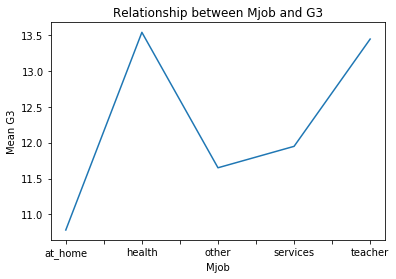

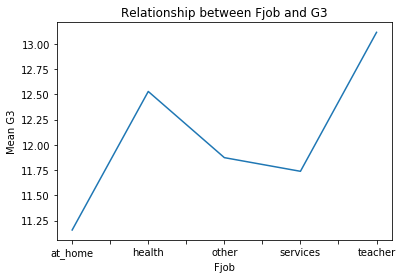

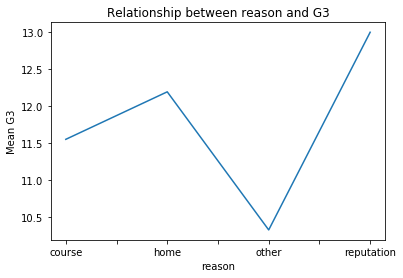

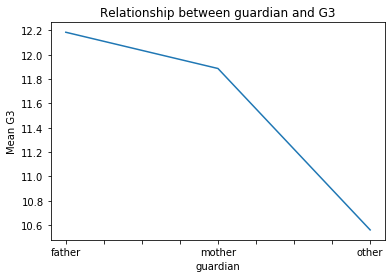

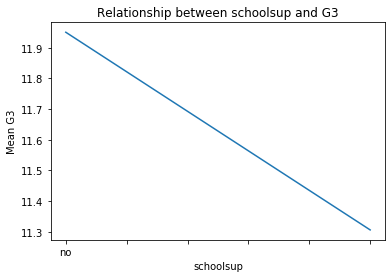

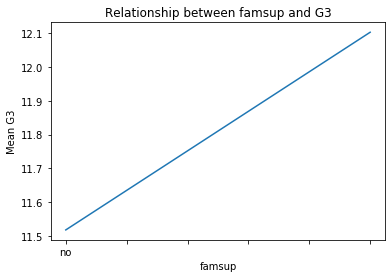

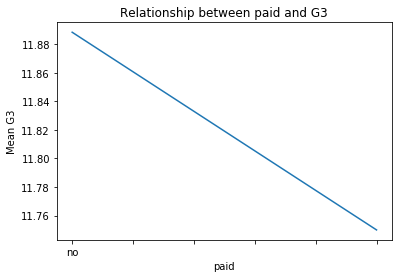

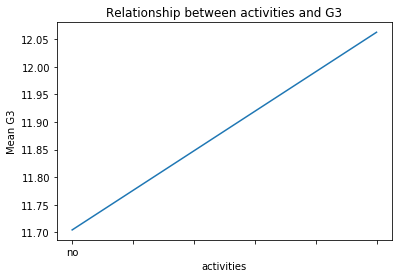

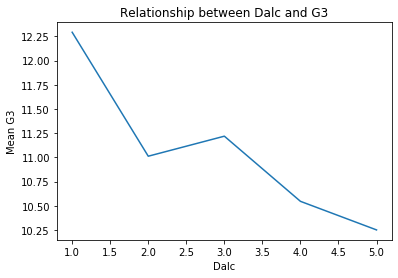

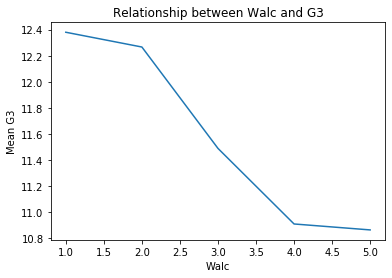

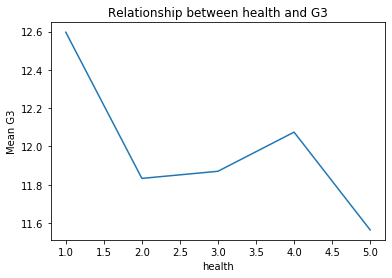

In [8]:
# let's explore the relationship of the categories with the target
columns.remove('G3')
for var in columns:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['G3'].mean().plot()
    fig.set_title('Relationship between {} and G3'.format(var))
    fig.set_ylabel('Mean G3')
    plt.show()

You can see that the relationship between the target and the categories of the categorical variables goes up and down, depending on the category.


## Ordered Integer encoding with pandas


### Advantages

- quick
- returns pandas dataframe

### Limitations of pandas:

- it does not preserve information from train data to propagate to test data

We need to store the encoding maps separately if planing to use them in production.

In [9]:
# let's order the labels according to the mean target value

X_train.groupby(['Mjob'])['G3'].mean().sort_values()

Mjob
at_home     10.780220
other       11.650000
services    11.949495
teacher     13.448980
health      13.542857
Name: G3, dtype: float64

In the above cell, we ordered the categories from the Mjob (mother's job) where the G3 (score) is lower when the mother stay at home, to highest G3 when the mother works in the health industry.

In the next cells, we will replace those categories, ordered as they are, by the numbers 0 to k, where k is the number of different categories minus 1, in this case 5 - 1 = 4.

So at_home will be replaced by 0 and health by 4, just to be clear.

In [10]:
# first  we generate an ordered list with the labels

ordered_labels = X_train.groupby(['Mjob'])['G3'].mean().sort_values().index

ordered_labels

Index(['at_home', 'other', 'services', 'teacher', 'health'], dtype='object', name='Mjob')

In [11]:
# next let's create a dictionary with the mappings of categories to numbers

ordinal_mapping = {k: i for i, k in enumerate(ordered_labels, 0)}

ordinal_mapping

{'at_home': 0, 'other': 1, 'services': 2, 'teacher': 3, 'health': 4}

In [12]:
# now, we replace the labels with the integers

X_train['Mjob'] = X_train['Mjob'].map(ordinal_mapping)
X_test['Mjob'] = X_test['Mjob'].map(ordinal_mapping)

C:\Users\gusal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\gusal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
X_train['Mjob'].head()

561    0
452    1
89     3
299    1
231    2
Name: Mjob, dtype: int64

In [14]:
# we can turn the previous commands into 2 functions


def find_category_mappings(df, variable, target):

    # first  we generate an ordered list with the labels
    ordered_labels = X_train.groupby([variable
                                      ])[target].mean().sort_values().index

    # return the dictionary with mappings
    return {k: i for i, k in enumerate(ordered_labels, 0)}


def integer_encode(train, test, variable, ordinal_mapping):

    X_train[variable] = X_train[variable].map(ordinal_mapping)
    X_test[variable] = X_test[variable].map(ordinal_mapping)
    print('ordinal mapping for {}: {}'.format(variable, ordinal_mapping))

In [15]:
columns.remove('Mjob')

In [16]:
columns

['Fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'Dalc',
 'Walc',
 'health']

In [17]:
# and now we run a loop over the remaining categorical variables

for variable in columns:

    mappings = find_category_mappings(X_train, variable, 'G3')

    integer_encode(X_train, X_test, variable, mappings)
    
    

ordinal mapping for Fjob: {'at_home': 0, 'services': 1, 'other': 2, 'health': 3, 'teacher': 4}
ordinal mapping for reason: {'other': 0, 'course': 1, 'home': 2, 'reputation': 3}
ordinal mapping for guardian: {'other': 0, 'mother': 1, 'father': 2}
ordinal mapping for schoolsup: {'yes': 0, 'no': 1}
ordinal mapping for famsup: {'no': 0, 'yes': 1}
ordinal mapping for paid: {'yes': 0, 'no': 1}
ordinal mapping for activities: {'no': 0, 'yes': 1}
ordinal mapping for Dalc: {5: 0, 4: 1, 2: 2, 3: 3, 1: 4}
ordinal mapping for Walc: {5: 0, 4: 1, 3: 2, 2: 3, 1: 4}
ordinal mapping for health: {5: 0, 2: 1, 3: 2, 4: 3, 1: 4}


C:\Users\gusal\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\gusal\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
# let's see the result

X_train.head()

,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,Dalc,Walc,health,G3
561,0,0,1,1,1,1,1,1,4,1,0,10
452,1,2,1,1,1,1,1,0,4,4,3,11
89,3,3,3,1,1,1,1,0,3,0,0,10
299,1,2,1,0,1,1,0,1,4,3,1,12
231,2,3,2,2,1,1,1,0,2,1,3,10


In [19]:
columns.append('Mjob')

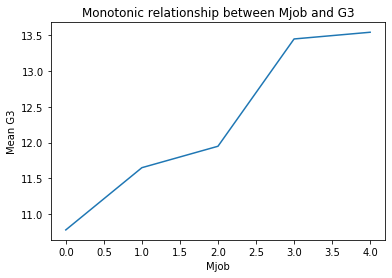

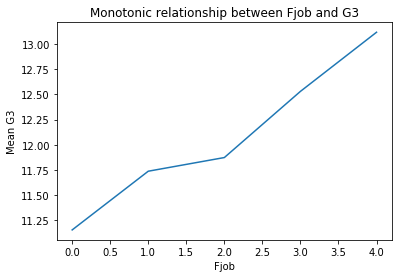

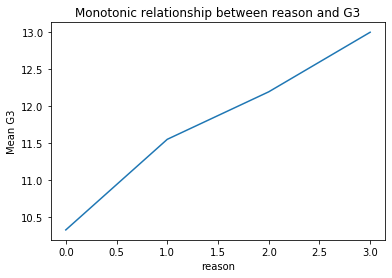

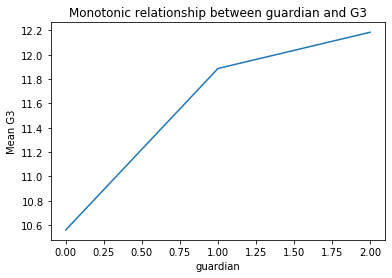

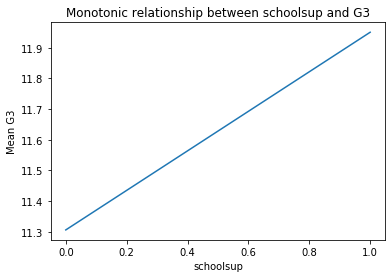

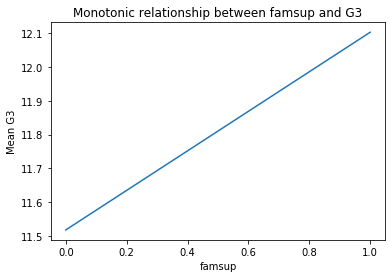

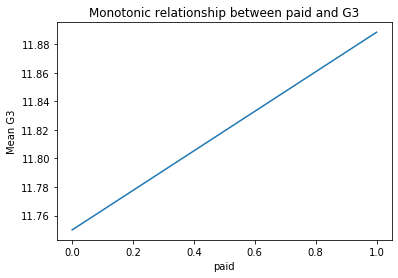

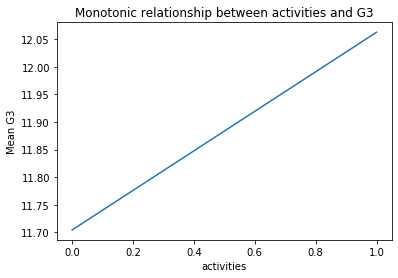

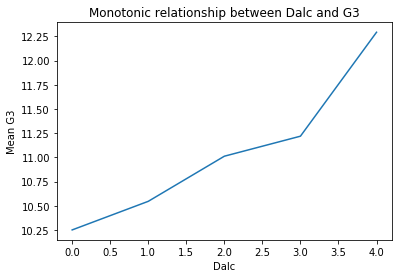

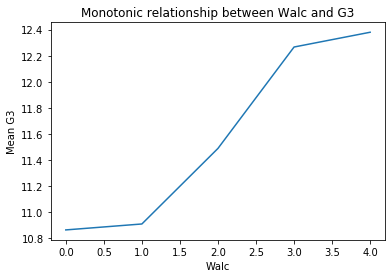

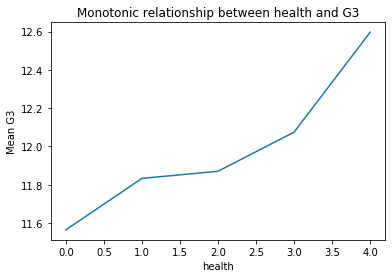

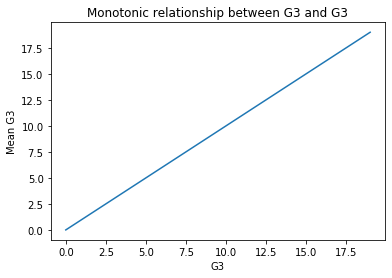

In [20]:
# let's inspect the newly created monotonic relationship
# between the variables and the target


for var in inputs.columns:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['G3'].mean().plot()
    fig.set_title('Monotonic relationship between {} and G3'.format(var))
    fig.set_ylabel('Mean G3')
    plt.show()

We see from the plots above that the relationship between the categories and the target is now monotonic, and for some  variables, almost linear, which helps improve linear models performance.

### Note

Monotonic does not mean strictly linear. Monotonic means that it increases constantly, or it decreases constantly.

Replacing categorical labels with this code and method will generate missing values for categories present in the test set that were not seen in the training set. Therefore it is extremely important to handle rare labels before-hand. I will explain how to do this, in a later notebook.

## Ordered Integer Encoding with Feature-Engine

If using Feature-Engine, instead of pandas, we do not need to keep the target variable in the training dataset.

'Dalc', 'Walc' , 'health' are categorical variables, but are taken as numerical, therefore they have to be re-cast

In [21]:
data_raw.Dalc = data_raw.Dalc.astype(object)
data_raw.Walc = data_raw.Walc.astype(object)
data_raw.health = data_raw.health.astype(object)


In [22]:
data_raw.dtypes

Mjob          object
Fjob          object
reason        object
guardian      object
schoolsup     object
famsup        object
paid          object
activities    object
Dalc          object
Walc          object
health        object
G3             int64
dtype: object

In [23]:
inputs = data_raw.drop(['G3'], axis = 1)
target = data_raw.G3

In [24]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    inputs,  # predictors
    target,  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((454, 11), (195, 11))

In [25]:
X_train.columns

Index(['Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid',
       'activities', 'Dalc', 'Walc', 'health'],
      dtype='object')

In [26]:
ordinal_enc = OrdinalCategoricalEncoder(
    # NOTE that we indicate ordered in the encoding_method, otherwise it assings numbers arbitrarily
    encoding_method='ordered',
    variables= ['Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid',
       'activities', 'Dalc', 'Walc', 'health'])
# If the argument variables is left to None, then the encoder will automatically identify all categorical variables.

In [27]:
# when fitting the transformer, we need to pass the target as well
# just like with any Scikit-learn predictor class

ordinal_enc.fit(X_train, y_train)

OrdinalCategoricalEncoder(encoding_method='ordered',
                          variables=['Mjob', 'Fjob', 'reason', 'guardian',
                                     'schoolsup', 'famsup', 'paid',
                                     'activities', 'Dalc', 'Walc', 'health'])

In [28]:
# in the encoder dict we can observe each of the top categories
# selected for each of the variables

ordinal_enc.encoder_dict_

{'Mjob': {'at_home': 0, 'other': 1, 'services': 2, 'teacher': 3, 'health': 4},
 'Fjob': {'at_home': 0, 'services': 1, 'other': 2, 'health': 3, 'teacher': 4},
 'reason': {'other': 0, 'course': 1, 'home': 2, 'reputation': 3},
 'guardian': {'other': 0, 'mother': 1, 'father': 2},
 'schoolsup': {'yes': 0, 'no': 1},
 'famsup': {'no': 0, 'yes': 1},
 'paid': {'yes': 0, 'no': 1},
 'activities': {'no': 0, 'yes': 1},
 'Dalc': {5: 0, 4: 1, 2: 2, 3: 3, 1: 4},
 'Walc': {5: 0, 4: 1, 3: 2, 2: 3, 1: 4},
 'health': {5: 0, 2: 1, 3: 2, 4: 3, 1: 4}}

In [29]:
# this is the list of variables that the encoder will transform

ordinal_enc.variables

['Mjob',
 'Fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'Dalc',
 'Walc',
 'health']

In [30]:
X_train = ordinal_enc.transform(X_train)
X_test = ordinal_enc.transform(X_test)

# let's explore the result
X_train.head()

,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,Dalc,Walc,health
561,0,0,1,1,1,1,1,1,4,1,0
452,1,2,1,1,1,1,1,0,4,4,3
89,3,3,3,1,1,1,1,0,3,0,0
299,1,2,1,0,1,1,0,1,4,3,1
231,2,3,2,2,1,1,1,0,2,1,3


**Note**

If the argument variables is left to None, then the encoder will automatically identify all categorical variables. Is that not sweet?

The encoder will not encode numerical variables. So if some of your numerical variables are in fact categories, you will need to re-cast them as object before using the encoder.

Finally, if there is a label in the test set that was not present in the train set, the encoder will through and error, to alert you of this behaviour.